<a href="https://colab.research.google.com/github/jamesfloe/cap-comp215/blob/main/Lab5_BestWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 215 - LAB 5 Cellular automata 
Date: April 12 2022


Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [ ]:
import os

if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py

%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate

## Zero-dimensional CA

Here's a simple implementation of the 0-D CA I mentioned in the book, with one cell.

In [ ]:
n = 10
x = np.zeros(n)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


To get the state of the cell in the next time step, we increment the current state mod 2.

In [ ]:
x[1] = (x[0] + 1) % 2
x[1]

1.0

Filling in the rest of the array.

In [ ]:
for i in range(2, n):
    x[i] = (x[i-1] + 1) % 2
    
print(x)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


So the behavior of this CA is simple: it blinks.

## One-dimensional CA

Just as we used a 1-D array to show the state of a single cell over time, we'll use a 2-D array to show the state of a 1-D CA over time, with one column per cell and one row per timestep.

In [ ]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


To plot the array I use `plt.imshow`

In [ ]:
def plot_ca(array):
    plt.imshow(array, cmap='Blues', interpolation='none')

Here's what it looks like after we initialize the first row.

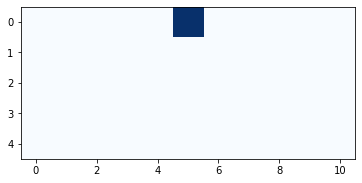

In [ ]:
plot_ca(array)

And here's the function that fills in the next row.  The rule for this CA is to take the sum of a cell and its two neighbors mod 2.

In [ ]:
def step(array, i):
    """Compute row i of a CA.
    """
    rows, cols = array.shape
    row = array[i-1]
    for j in range(1, cols):
        elts = row[j-1:j+2]
        array[i, j] = sum(elts) % 2

Here's the second row.

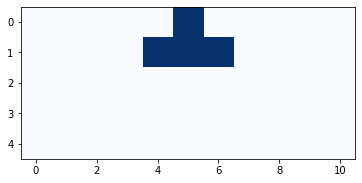

In [ ]:
step(array, 1)
plot_ca(array)

And here's what it looks like with the rest of the cells filled in.

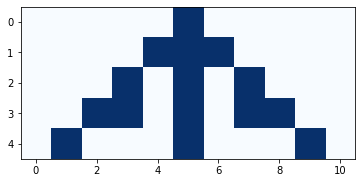

In [ ]:
for i in range(1, rows):
    step(array, i)

plot_ca(array)

For a simple set of rules, the behavior is more interesting than you might expect.

**Exercise:** Modify this code to increase the number of rows and columns and see what this CA does after more time steps.

## Cross correlation

We can update the CA more quickly using "cross correlation".  The cross correlation of an array, `a`, with a window, `w`, is a new array, `c`, where element `k` is:

$ c_k = \sum_{n=0}^{N-1} a_{n+k} \cdot w_n $

In Python, we can compute element `k` like this:

In [ ]:
def c_k(a, w, k):
    """Compute element k of the cross correlation of a and w.
    """
    N = len(w)
    return sum(a[k:k+N] * w)

To see how this works, I'll create an array:

In [ ]:
N = 10
row = np.arange(N, dtype=np.uint8)
print(row)

[0 1 2 3 4 5 6 7 8 9]


And a window:

In [ ]:
window = [1, 1, 1]

print(window)

[1, 1, 1]


With this window, each element of `c` is the sum of three neighbors in the array:

In [ ]:
c_k(row, window, 0)

3

In [ ]:
c_k(row, window, 1)

6

The following function computes the elements of `c` for all values of `k` where the window can overlap with the array:

In [ ]:
def correlate(row, window):
    """Compute the cross correlation of a and w.
    """
    cols = len(row)
    N = len(window)
    c = [c_k(row, window, k) for k in range(cols-N+1)]
    return np.array(c)

In [ ]:
c = correlate(row, window)
print(c)

[ 3  6  9 12 15 18 21 24]


This operation is useful in many domains, so libraries like NumPy usually provide an implementation.  Here's the version from NumPy.

In [ ]:
c = np.correlate(row, window, mode='valid')
print(c)

[ 3  6  9 12 15 18 21 24]


With `mode='valid'`, the NumPy version does the same thing as mine: it only computes the elements of `c` where the window overlaps with the array.  A drawback of this mode is that the result is smaller than `array`.

And alternative is `mode='same'`, which makes the result the same size as `array` by extending array with zeros on both sides.  Here's the result:

In [ ]:
c = np.correlate(row, window, mode='same')
print(c)

[ 1  3  6  9 12 15 18 21 24 17]


**Exercise 1 correlate (sliding dot product)**

a) Write a version of correlate that returns the same result as
np.correlate with mode='same'.

b) Notice this “pads” the row with zeros at either end, which will create a bias at the edge of the
automata. It would be ideal if the edges “wrapped”. Update your algorithm so it pads each end of
the row with values from the opposite end, effectively connecting the two edges of the CA.

c) Lookup the documentation for the np.pad function and notice it has a “wrap” mode. Do a small
experiment to see if np.pad(...., mode=”wrap”) works the same as your padding
algorithm.

In [ ]:
# Hint: use np.pad to add zeros at the beginning and end of `row`


In [ ]:

def myCorrelate(row, window):
    """Compute the cross correlation of a and w.
    """
    N = len(window)
    padded_c = np.pad(row, (1,), 'constant', constant_values=(0,0))
    cols = len(padded_c)
    print(padded_c)
    c = [c_k(padded_c, window, k) for k in range(cols-N+1)]
    return np.array(c)

c = myCorrelate(row, window)
print(c)

[0 0 1 2 3 4 5 6 7 8 9 0]
[ 1  3  6  9 12 15 18 21 24 17]


In [ ]:
#Excercise 1 (b,c)

#1,
def myExperimentalCorrelate(row, window):
    """Compute the cross correlation of a and w.
    """
    N = len(window)
    padded_c = np.pad(row, (1,), mode='wrap')
    cols = len(padded_c)
    print(padded_c)
    c = [c_k(padded_c, window, k) for k in range(cols-N+1)]
    return np.array(c)

c = myExperimentalCorrelate(row, window)
print(c)
#1c 
#Results are similar to my correlate function, except for the beginning.


[9 0 1 2 3 4 5 6 7 8 9 0]
[10  3  6  9 12 15 18 21 24 17]


## Update with correlate

Now we can use `np.correlate` to update the array.  I'll start again with an array that contains one column for each cell and one row for each time step, and I'll initialize the first row with a single "on" cell in the middle:

In [ ]:
rows = 5
cols = 11
array = np.zeros((rows, cols), dtype=np.uint8)
array[0, 5] = 1
print(array)

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]


Now here's a version of `step` that uses `np.correlate`

In [ ]:
def step2(array, i, window=[1,1,1]):
    """Compute row i of a CA.
    """
    row = array[i-1]
    c = np.correlate(row, window, mode='same')
    array[i] = c % 2

And the result is the same.

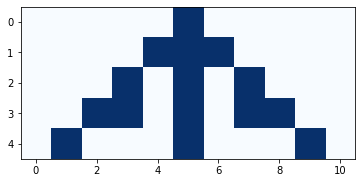

In [ ]:
for i in range(1, rows):
    step2(array, i)

plot_ca(array)

## The Cell1D object

`Cell1D` encapsulates the code from the previous section.

In [ ]:
class Cell1D:
    """Represents a 1-D a cellular automaton"""

    def __init__(self, rule, n, m=None):
        """Initializes the CA.

        rule: integer
        n: number of rows
        m: number of columns

        Attributes:
        table:  rule dictionary that maps from triple to next state.
        array:  the numpy array that contains the data.
        next:   the index of the next empty row.
        """
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m

        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0

    def start_single(self):
        """Starts with one cell in the middle of the top row."""
        self.array[0, self.m//2] = 1
        self.next += 1

    def start_random(self, prop):
        """Start with random values in the top row."""
        randoms = [0,1]
        self.array[0] = np.array([int(np.random.choice(randoms, 1, p=[prop, 1-prop])) for item in range(self.m)])
        self.next += 1
        print(self.array)

    def start_string(self, s):
        """Start with values from a string of 1s and 0s."""
        self.array[0] = np.array([int(x) for x in s])
        self.next += 1

    def loop(self, steps=1):
        """Executes the given number of time steps."""
        for i in range(steps):
            self.step()

    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

    def draw(self, start=0, end=None):
        """Draws the CA using pyplot.imshow.

        start: index of the first column to be shown
        end: index of the last column to be shown
        """
        a = self.array[:, start:end]
        plt.imshow(a, cmap='Blues', alpha=0.7)
        
        # turn off axis tick marks
        plt.xticks([])
        plt.yticks([])

The following function makes and draws a CA.

In [ ]:
def draw_ca(rule, n=32):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    ca.loop(n-1)
    ca.draw()

Here's an example that runs a Rule 50 CA for 10 steps.

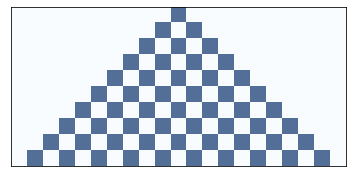

In [ ]:
draw_ca(rule=50, n=10)
plt.show('figs/chap05-1')

Another example:

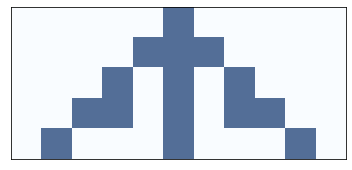

In [ ]:
draw_ca(rule=150, n=5)

plt.show('figs/chap05-2')

And one more example showing recursive structure.

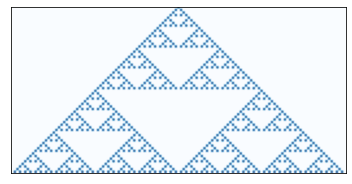

In [ ]:
draw_ca(rule=18, n=64)

plt.show('figs/chap05-3')

Rule 30 generates a sequence of bits that is indistinguishable from random:

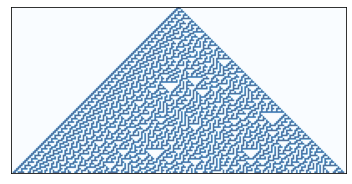

In [ ]:
draw_ca(rule=30, n=100)

plt.show('figs/chap05-4')

And Rule 110 is Turing complete!

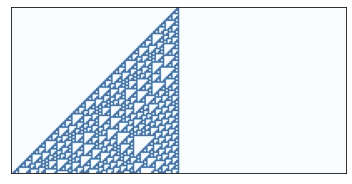

In [ ]:
draw_ca(rule=110, n=100)

plt.show('figs/chap05-5')

Here's a longer run that has some spaceships.

[[0 0 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


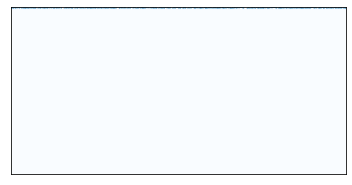

In [ ]:
np.random.seed(21)
ca = Cell1D(rule=110, n=600)
ca.start_random(prop=0.5)
ca.loop(n-1)
ca.draw()

plt.show('figs/chap05-6')

**Exercise 2 make_table**

This function is effectively a decimal to binary conversion with 3 important constraints:

a) the “bit string” output is an numpy.array of 0’s and 1’s

b) the length of the output bit string is fixed – it is always 8 bits long

c) the bit ordering appears “reversed” because of the way sequence are printed (with index 0 first)

i.e., the lowest-order bit is at index 0 and the highest-order bit at index 7
Develop your own version of function make_table(rule) that adheres to the same constraints, but
does not use numpy to unpack the bits.

Hints:
- do some examples with pencil-and-paper – you can “extract” bits from an integer with the
modulus operator, %, and you can “pop” bits off an integer with the integer divide operator, //;
- this is a list accumulator algorithm but is not easily written as a list comprehension – try a while
loop;
- pad the front of the bit-string with zeros to make it the right length – try: [0] * n

In [ ]:
# Excercise 2 make_table

def myMake_Table(rule):
  binString = ''
  zero = 0
  while rule >= 1:
    binString = binString + str(rule%2)
    rule = rule // 2

  c = [int(item) for item in binString]
  for i in range((abs(len(c) - 8))):
    c.append(zero)
  
  d = np.array(c)
  return d



    
z = myMake_Table(50)
print(z)

[0 1 0 0 1 1 0 0]


**Exercise 3 start_random**

The start_random method of Cell1D distributes on/off cells with a "uniform distribution", such that
approx. half the cells are on and half off. Add a default parameter p=0.5, that distributes “on” cells
with probability p, on [0..1]. E.g. when p=0.2, only approx. 20% of cells are randomly turned “on”.

Hints:

- this is neatly written as a list comprehension;
- but needs to be returned as a np.array with dtype=np.uint8

Upgrade draw_ca function so you can optionally pass in value of p. If p is None (default value),
draw_ca works as usual. If p is not None, then ca.start_random is called with the value of p. 


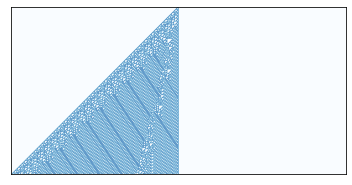

In [ ]:

def mydraw_ca(rule, n, p):
    """Makes and draw a 1D CA with a given rule.
    
    rule: int rule number
    n: number of rows
    """
    ca = Cell1D(rule, n)
    if p == 'none':
      ca.start_single()
    else:
      ca.start_random(p)

    ca.loop(n-1)
    ca.draw()
    
mydraw_ca(110, 400, 'none')


**Exercise 4 CA experiment**

Experiment with these basic CA to identify at least 1 example from each of Wolfram’s 4 CA “classes” :
1. rapidly converge to a uniform state.
2. rapidly converge to a repetitive or stable state.
3. generate non-repeating, random states.
4. generate chaos, with areas of repetitive or stable states, but also structures that interact
complex ways.
Create a 2x2 grid of plots that shows an example of each class of CA side-by-side.
Hint: plt.subplots(nrows=2, ncols=2) returns a 2x2 array of axes – see matplotlib docs.
 What does it mean that such a simple system can produce this range of behaviours?
 What lessons or conclusions might we draw about studying complex phenomena in the real
world from our study of elementary cellular automata? 


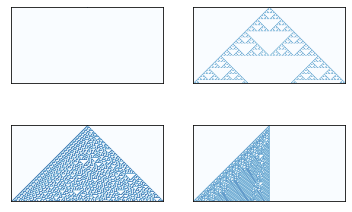

In [ ]:
#Experiment 4 CA Experiment

# 1. Rule 0 will rapidly converge to a uniform state.
# 2. Rule 18 will converge to a repititive state.
# 3. Rule 30 is a class 3 rule, generating non-repeating random states.
# 4. Rule 110 is a class 4 rule, generating stable and non-stable areas, with areas that appear like spaceships, interacting in complex ways along each time-step.

plt.subplot(2, 2, 1)
draw_ca(rule=0, n = 100)

plt.subplot(2,2,2)
draw_ca(rule=18, n = 100)

plt.subplot(2,2,3)
draw_ca(rule=30, n = 100)

plt.subplot(2,2,4)
draw_ca(rule=110, n = 200)

#This system producing these wide range of behaviours, signifies that even a simple algorithm
#can produce complex results over time.

#We can see in the real world how simple living things, such as viruses, or monocellular organisms can
#be produced from a very simple pattern or 'seed.' 



